In [1]:
# os.chdir("hmr4d/")
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
from pathlib import Path
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image
import lovely_tensors as lt
lt.monkey_patch()
import imageio.v3 as iio
import torch

from hmr4d.network.gvhmr.relative_transformer import NetworkEncoderRoPE
from hmr4d.model.gvhmr.utils.endecoder import EnDecoder
from hmr4d.model.gvhmr.pipeline.gvhmr_pipeline import get_smpl_params_w_Rt_v2
from hmr4d.model.gvhmr.utils.postprocess import (
    pp_static_joint,
    process_ik,
    pp_static_joint_cam,
)

from hmr4d.utils.preproc import Tracker, Extractor, VitPoseExtractor, SimpleVO
from hmr4d.utils.geo.hmr_cam import get_bbx_xys_from_xyxy, estimate_K, create_camera_sensor
from hmr4d.utils.geo.hmr_cam import compute_bbox_info_bedlam, compute_transl_full_cam, normalize_kp2d
from hmr4d.utils.geo_transform import compute_cam_angvel, move_to_start_point_face_z
from hmr4d.utils.body_model import BodyModelSMPLH, BodyModelSMPLX
from hmr4d.utils.video_io_utils import get_writer, get_video_reader, read_video_np, save_video
from hmr4d.utils.vis.renderer import Renderer, get_global_cameras_static, get_ground_params_from_points
from hmr4d.utils.vis.cv2_utils import draw_bbx_xyxy_on_image_batch, draw_kpts_with_conf_batch, draw_kpts_batch
from hmr4d.utils.vis.plot_vis import plot_angle_changes

/home/guangyu/anaconda3/envs/hmr/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
# video_path = Path("samples/bodycam/Fresh Out of Jail, Neighbor From Hell Strikes Again [ZVZo5O5vbXQ].mp4")
# start_time = 770
# end_time = 774
# out_path = Path("samples/test_dataset/ZVZo5O5vbXQ=5.mp4")

# reader = get_video_reader(video_path)
# meta = iio.immeta(video_path)
# print(meta)
# fps = meta["fps"]
# start_frame = int(start_time * fps)
# end_frame = int(end_time * fps)

# frames = read_video_np(video_path, start_frame=start_frame, end_frame=end_frame)
# print(frames.shape)
# save_video(frames, out_path, fps=int(fps))

### 1. parse_args_to_cfg

In [3]:
# demo.py -> L41~55
video_path = Path("samples/test_dataset/Hs_HtOkCB4Y=1.mp4")
output_root = Path("outputs/test_dataset")
output_root.mkdir(parents=True, exist_ok=True)
static_cam = False
use_dpvo = False
f_mm = None

# demo.py -> L60
# hmr4d.utils.video_io_utils.get_video_lwh
length, height, width, c = iio.improps(video_path, plugin="pyav").shape
if length == 0:
    video = cv2.VideoCapture(str(video_path))
    fps = video.get(cv2.CAP_PROP_FPS)
    length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))-1
print(f"{str(video_path)}: {width}x{height}x{length}")

samples/test_dataset/Hs_HtOkCB4Y=1.mp4: 1920x1080x120


### 2. Run Preprocess

In [4]:
tracker = Tracker()
vitpose_extractor = VitPoseExtractor()
extractor = Extractor()

In [5]:
track_history = tracker.track(video_path)
vid_length = len(track_history)
id_to_frame_ids, id_to_bbx_xyxys, id_sorted = tracker.sort_track_length(track_history, video_path)

for k in id_sorted:
    lst = id_to_frame_ids[k]
    ranges = np.split(lst, np.where(np.diff(lst)!=1)[0]+1)
    ranges = [(x[0], x[-1]) if len(x) > 1 else (x[0], x[0]) for x in ranges]
    print(f"track id {k}: {len(lst)} frames, ranges: {ranges}")

# bbx_xyxy = tracker.get_one_track(video_path, track_id=107).float()  # (L, 4)
# # bbx_xyxy = tracker.get_one_track(video_path, imgsize=960, track_id=1, print_res=True).float()
# bbx_xys = get_bbx_xys_from_xyxy(bbx_xyxy, base_enlarge=1.2).float()

YoloV8 Tracking: 100%|██████████| 120/120 [00:04<00:00, 26.59it/s]


track id 1: 120 frames, ranges: [(0, 119)]
track id 3: 20 frames, ranges: [(78, 97)]
track id 4: 2 frames, ranges: [(91, 91), (119, 119)]


In [6]:
track_ids = [1]
frame_ids, bbx_xyxys = [], []
for track_id in track_ids:
    tmp_id = torch.tensor(id_to_frame_ids[track_id])  # (N,)
    frame_ids.append(tmp_id)
    tmp_xyxy = torch.tensor(id_to_bbx_xyxys[track_id])  # (N, 4)
    bbx_xyxys.append(tmp_xyxy)
frame_ids = torch.cat(frame_ids)
bbx_xyxys = torch.cat(bbx_xyxys)

bbx_xyxy = tracker.interpolate_smooth_bbx(frame_ids, bbx_xyxys, length=vid_length)
bbx_xys = get_bbx_xys_from_xyxy(bbx_xyxy, base_enlarge=1.2).float()

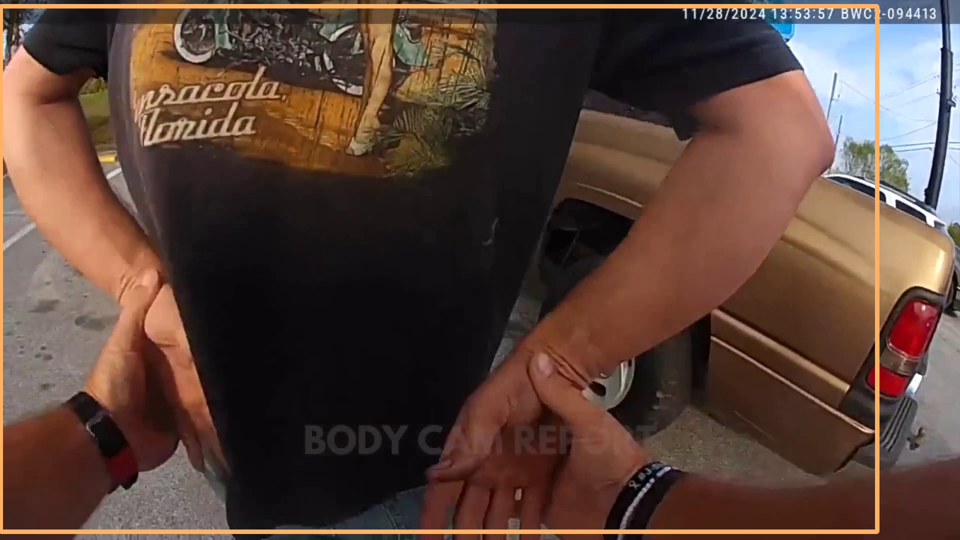

In [7]:
i = 100
img = iio.imread(video_path, index=i)  # (L, H, W, 3) RGB
video_overlay = draw_bbx_xyxy_on_image_batch(bbx_xyxy[i:i+1], [img], thickness=8)
Image.fromarray(video_overlay[0]).resize((width // 2, height // 2))

In [8]:
vitpose = vitpose_extractor.extract(str(video_path), bbx_xys) # (L, 17, 3)
vit_features = extractor.extract_video_features(str(video_path), bbx_xys) # (L, 1024)

HMR2 Feature: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


In [15]:
simple_vo = SimpleVO(video_path, scale=0.5, step=8, method="sift", f_mm=None)
vo_results = simple_vo.compute() # (L, 4, 4)
R_w2c = torch.from_numpy(vo_results[:, :3, :3]) # (L, 3, 3)
K_fullimg = estimate_K(width, height).repeat(length, 1, 1) # (L, 3, 3)

[SimpleVO] Choosen frames shape: (16, 540, 960, 3)
TwoViewGeometryOptions:
    min_num_inliers = 10
    min_E_F_inlier_ratio = 0.8
    max_H_inlier_ratio = 0.9
    watermark_min_inlier_ratio = 0.7
    watermark_border_size = 0.1
    detect_watermark = True
    multiple_ignore_watermark = True
    watermark_detection_max_error = 4.0
    filter_stationary_matches = False
    stationary_matches_max_error = 4.0
    force_H_use = False
    compute_relative_pose = True
    multiple_models = False
    ransac: RANSACOptions:
        max_error = 4.0
        min_inlier_ratio = 0.25
        confidence = 0.999
        dyn_num_trials_multiplier = 3.0
        min_num_trials = 100
        max_num_trials = 10000
        random_seed = -1


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


In [ ]:
# final_results = torch.load("outputs/test_dataset/mbwduDLotLI=2.pt")
# video_path = Path(final_results['input_video'])
# length, width, height = final_results["dimensions"]
# bbx_xys = final_results["bbx_xys"]
# vitpose = final_results["vitpose"]
# vit_features = final_results["vit_features"]
# vo_results = final_results["vo_results"]
# R_w2c = torch.from_numpy(vo_results[:, :3, :3]) # (L, 3, 3)
# K_fullimg = final_results["K_fullimg"]

### 3. Model Inference

In [16]:
denoiser3d = NetworkEncoderRoPE().eval().cuda()
endecoder = EnDecoder(stats_name="MM_V1_AMASS_LOCAL_BEDLAM_CAM").eval().cuda()

cam_angvel_mean = torch.tensor([1., 0., 0., 0., 1., 0.], device='cuda')
cam_angvel_std = torch.tensor( [1e-3, 0.1, 0.1, 0.1, 1e-3, 0.1], device='cuda')

state_dict = torch.load('inputs/checkpoints/gvhmr/gvhmr_siga24_release.ckpt')['state_dict']
transf_state_dict = {key.replace("pipeline.denoiser3d.", ""): value for key, value in state_dict.items() if "pipeline.denoiser3d." in key}
denoiser3d.load_state_dict(transf_state_dict)

[01/13 09:22:04][INFO] [EnDecoder] Use MM_V1_AMASS_LOCAL_BEDLAM_CAM for statistics!


<All keys matched successfully>

In [17]:
cliff_cam = compute_bbox_info_bedlam(bbx_xys[None], K_fullimg[None]).to('cuda')  # (B, L, 3)
f_cam_angvel = compute_cam_angvel(R_w2c).to('cuda')
f_condition = {
    "obs": normalize_kp2d(vitpose, bbx_xys)[None].to('cuda'),  # (B, L, J, 3)
    "f_cliffcam": cliff_cam,  # (B, L, 3)
    "f_cam_angvel": (f_cam_angvel - cam_angvel_mean) / cam_angvel_std,  # (B, L, C=6)
    # "f_imgseq": vit_features[None].to('cuda'),  # (B, L, C=1024)
    "f_imgseq": torch.zeros_like(vit_features)[None].to('cuda')
}

In [18]:
with torch.no_grad():
    model_output = denoiser3d(length=torch.tensor([length], device='cuda'), **f_condition)  # pred_x, pred_cam, static_conf_logits
    decode_dict = endecoder.decode(model_output["pred_x"]) 

In [19]:
outputs = {}
# Post-processing
outputs["pred_smpl_params_incam"] = {
    "body_pose": decode_dict["body_pose"],  # (B, L, 63)
    "betas": decode_dict["betas"],  # (B, L, 10)
    "global_orient": decode_dict["global_orient"],  # (B, L, 3)
    "transl": compute_transl_full_cam(
        model_output["pred_cam"], bbx_xys.to('cuda'), K_fullimg.to('cuda')),
}

pred_smpl_params_global = get_smpl_params_w_Rt_v2(  # This function has for-loop
    global_orient_gv=decode_dict["global_orient_gv"],
    local_transl_vel=decode_dict["local_transl_vel"],
    global_orient_c=decode_dict["global_orient"],
    cam_angvel=f_cam_angvel[None],
)
outputs["pred_smpl_params_global"] = {
    "body_pose": decode_dict["body_pose"],
    "betas": decode_dict["betas"],
    **pred_smpl_params_global,
}
outputs["static_conf_logits"] = model_output["static_conf_logits"]

if static_cam:  # extra post-processing to utilize static camera prior
    outputs["pred_smpl_params_global"]["transl"] = pp_static_joint_cam(outputs, endecoder)
else:
    outputs["pred_smpl_params_global"]["transl"] = pp_static_joint(outputs, endecoder)

body_pose = process_ik(outputs, endecoder)
decode_dict["body_pose"] = body_pose
outputs["pred_smpl_params_global"]["body_pose"] = body_pose
outputs["pred_smpl_params_incam"]["body_pose"] = body_pose

pred = {
    "smpl_params_global": {k: v[0] for k, v in outputs["pred_smpl_params_global"].items()},
    "smpl_params_incam": {k: v[0] for k, v in outputs["pred_smpl_params_incam"].items()},
}

In [56]:
final_results = {
    "input_video" : str(video_path.absolute()),
    "dimensions" : (length, width, height),
    "bbx_xyxy": bbx_xyxy, "bbx_xys": bbx_xys,
    "vitpose": vitpose,
    'vit_features': vit_features,
    'vo_results': vo_results,
    'K_fullimg': K_fullimg,
    'smpl_params_global' :pred["smpl_params_global"],
    'smpl_params_incam' :pred["smpl_params_incam"],
    'static_conf_logits': outputs['static_conf_logits'][0]
}
# torch.save(final_results, output_root / f"{video_path.stem}.pt")

### 4. Render InCamera View

In [20]:
smpl = BodyModelSMPLH(
    model_path="inputs/checkpoints/body_models", model_type="smpl",
    gender="neutral", num_betas=10, create_body_pose=False, 
    create_betas=False, create_global_orient=False, create_transl=False,
).cuda()
smplx = BodyModelSMPLX(
    model_path="inputs/checkpoints/body_models", model_type="smplx",
    gender="neutral", num_pca_comps=12, flat_hand_mean=False,
).cuda()
smplx2smpl = torch.load("hmr4d/utils/body_model/smplx2smpl_sparse.pt").cuda()
faces_smpl = smpl.faces
J_regressor = torch.load("hmr4d/utils/body_model/smpl_neutral_J_regressor.pt").cuda()

r_width, r_height = width, height # 
# r_width, r_height = width//4, height//4

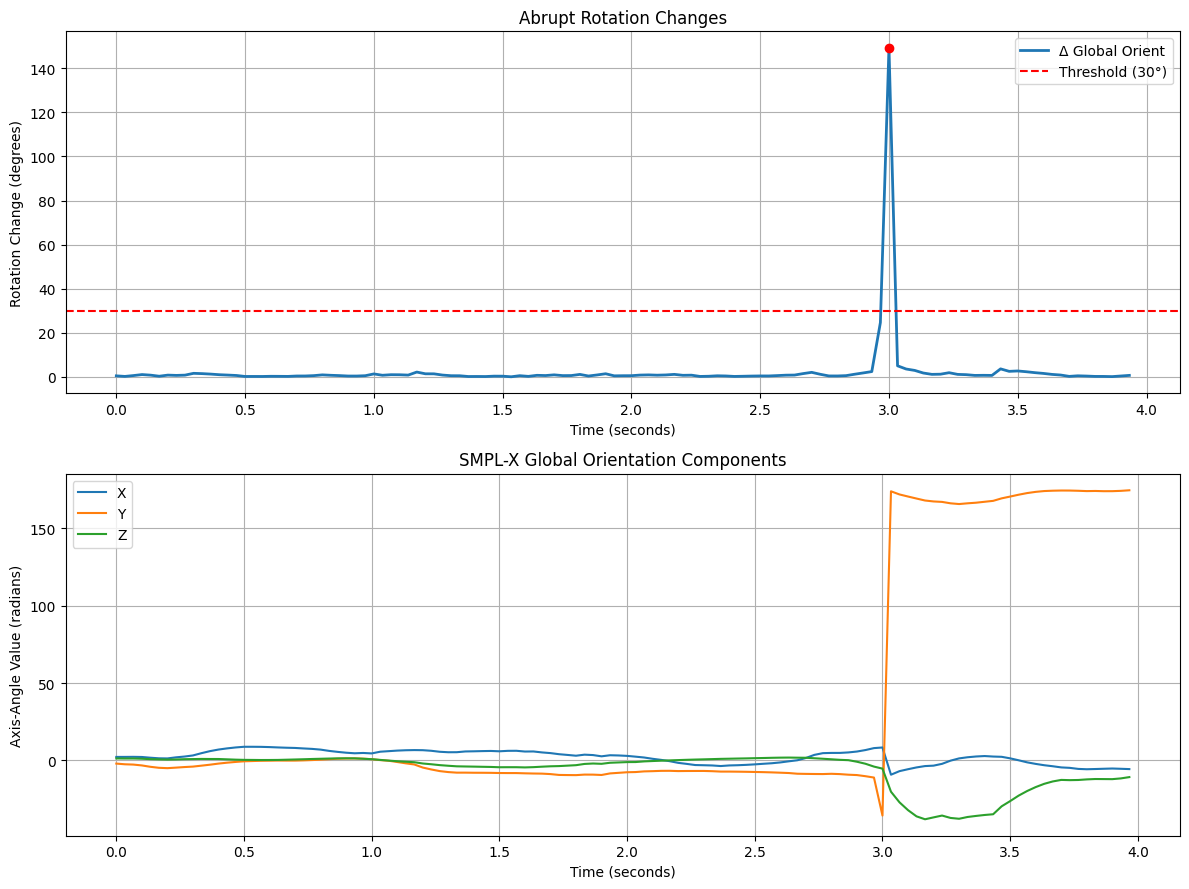

In [58]:
# final_results = torch.load(output_root / f"{video_path.stem}.pt")
length, width, height = final_results['dimensions']
plot_angle_changes(final_results["smpl_params_global"]['global_orient'])

In [59]:
# smpl
renderer_c = Renderer(r_width, r_height, device="cuda", faces=faces_smpl, K=estimate_K(r_width, r_height))

smplx_c = smplx(**final_results["smpl_params_incam"])
pred_c_verts = torch.stack([torch.matmul(smplx2smpl, v_) for v_ in smplx_c.vertices])
pred_c_joints, pred_c_valid = renderer_c.project_points_to_full_image(smplx_c.joints)

In [60]:
smplx_gb = smplx(**final_results["smpl_params_global"])
pred_gb_verts = torch.stack([torch.matmul(smplx2smpl, v_) for v_ in smplx_gb.vertices])
pred_gb_verts, pred_gb_joints = move_to_start_point_face_z(pred_gb_verts, J_regressor)

global_R, global_T, global_lights = get_global_cameras_static(
    pred_gb_joints.cpu(), beta=4.0, cam_height_degree=20, target_center_height=1.0
)
_, _, K = create_camera_sensor(r_width, r_height, 24)
renderer_g = Renderer(r_width, r_height, device="cuda", faces=faces_smpl, K=K)

# -- render mesh -- #
scale, cx, cz = get_ground_params_from_points(pred_gb_joints[:, 0], pred_gb_verts)
renderer_g.set_ground(scale * 1.5, cx, cz)
color = torch.ones(3).float().cuda() * 0.8


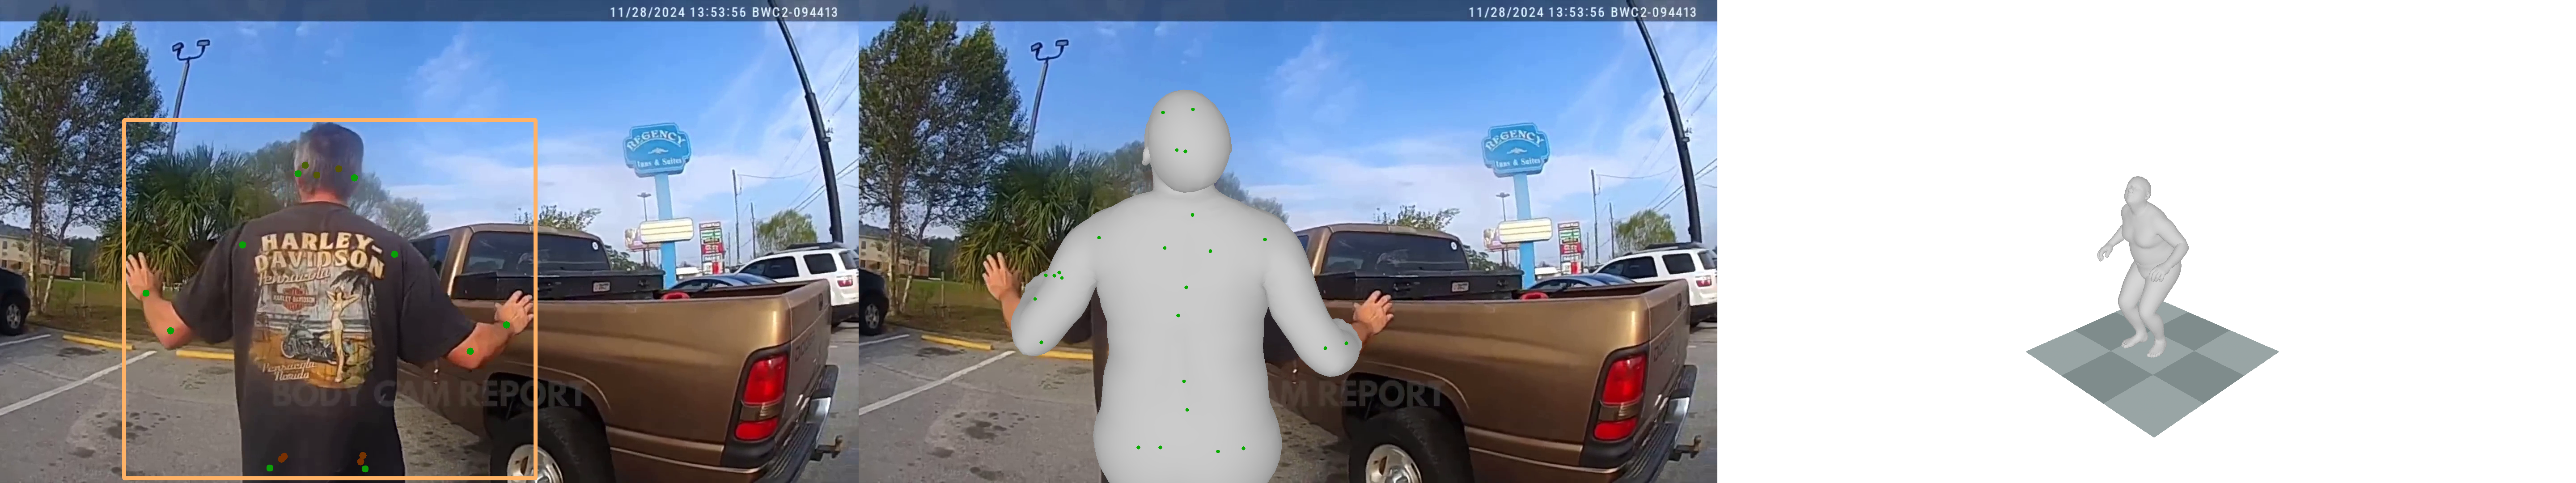

In [61]:
i = 60

img_raw = cv2.resize(iio.imread(final_results['input_video'], index=i), (r_width, r_height))
img_annot = draw_bbx_xyxy_on_image_batch(final_results['bbx_xyxy'][i:i+1], [img_raw], thickness=8)[0]
img_annot = draw_kpts_with_conf_batch(
    [img_annot[..., ::-1]], final_results['vitpose'][i:i+1, ..., :2], 
                            final_results['vitpose'][i:i+1, ...,  2], thickness=8)[0][...,::-1]

img_cam = renderer_c.render_mesh(pred_c_verts[i].cuda(), img_raw, colors=[0.8, 0.8, 0.8])
img_cam = draw_kpts_with_conf_batch([img_cam], pred_c_joints[i:i+1][:,:-98], pred_c_valid[i:i+1][:,:-98], thickness=4)[0]

cameras = renderer_g.create_camera(global_R[i], global_T[i])
img_gb = renderer_g.render_with_ground(pred_gb_verts[[i]], color[None], cameras, global_lights)

Image.fromarray(np.concatenate([img_annot, img_cam, img_gb], axis=1))

In [ ]:
# writer = get_writer(output_root / f'{video_path.stem}.mp4', fps=30, crf=23)
writer = get_writer(f'tmp.mp4', fps=30, crf=23)
for i in tqdm(range(length), desc=f"Rendering Global"):
    img_raw = cv2.resize(iio.imread(final_results['input_video'], index=i), (r_width, r_height))
    img_raw = draw_bbx_xyxy_on_image_batch(final_results['bbx_xyxy'][i:i+1], [img_raw], thickness=8)[0]
    # img_raw = draw_kpts_with_conf_batch([img_raw], pred_c_joints[i:i+1], pred_c_valid[i:i+1], thickness=4)[0]

    img_cam = renderer_c.render_mesh(pred_c_verts[i].cuda(), img_raw, colors=[0.8, 0.8, 0.8])
    img_cam = draw_kpts_with_conf_batch([img_cam], pred_c_joints[i:i+1], pred_c_valid[i:i+1], thickness=4)[0]

    cameras = renderer_g.create_camera(global_R[i], global_T[i])
    img_gb = renderer_g.render_with_ground(pred_gb_verts[[i]], color[None], cameras, global_lights)
    img = np.concatenate([img_raw, img_cam, img_gb], axis=1)
    writer.write_frame(img)
writer.close()

Rendering Global:   0%|          | 0/600 [00:00<?, ?it/s]

Rendering Global:  88%|████████▊ | 530/600 [02:11<00:19,  3.52it/s]

Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.

Rendering Global:  89%|████████▊ | 532/600 [02:12<00:19,  3.50it/s]

Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size 

Rendering Global: 100%|██████████| 600/600 [02:32<00:00,  3.95it/s]


In [ ]:
# from hmr4d.utils.vis.renderer import overlay_image_onto_background

# i = 250

# cameras = renderer_g.create_camera(global_R[i], global_T[i])
# img_gb = renderer_g.render_with_ground(pred_gb_verts[[i]], color[None], cameras, global_lights)

# frust_verts_cam, frust_faces = frustum_vertices_in_camera(K.cuda(), W=r_width, H=r_height, z_near=1.0)
# frust_verts_wld = camera_to_world_points(frust_verts_cam, R_cw=R_cw_all[i], t_cw=t_cw_all[i,...,0])

# vertices=frust_verts_wld.to('cuda')
# faces=frust_faces.unsqueeze(0).to('cuda')
# background=img_gb
# colors=[0.0, 0.8, 0.8]
# update_bbox=False
# flip=False

# if update_bbox:
#     renderer_g.update_bbox(vertices[::50], scale=1.2)
# vertices = vertices.unsqueeze(0)

# if isinstance(colors, torch.Tensor):
#     # per-vertex color
#     verts_features = colors.to(device=vertices.device, dtype=vertices.dtype)
#     colors = [0.8, 0.8, 0.8]
# else:
#     if colors[0] > 1:
#         colors = [c / 255.0 for c in colors]
#     verts_features = torch.tensor(colors).reshape(1, 1, 3).to(device=vertices.device, dtype=vertices.dtype)
#     verts_features = verts_features.repeat(1, vertices.shape[1], 1)
# textures = TexturesVertex(verts_features=verts_features)

# if faces is None:
#     faces = renderer_g.faces
# mesh = Meshes(verts=vertices, faces=faces, textures=textures)

# materials = Materials(device=renderer_g.device, specular_color=(colors,), shininess=0)

# results = renderer_g.renderer(mesh, materials=materials, cameras=renderer_g.cameras, lights=renderer_g.lights)
# if flip:
#     results = torch.flip(results, [1, 2])
# image = results[0, ..., :3] * 255
# mask = results[0, ..., -1] > 1e-3

# if background is None:
#     background = np.ones((renderer_g.height, renderer_g.width, 3)).astype(np.uint8) * 255
    
# if update_bbox:
#     bbox = renderer_g.bboxes
# else:
#     bbox = torch.tensor([[0, 0, renderer_g.width, renderer_g.height]]).float().to(renderer_g.device)

# image = overlay_image_onto_background(image, mask, bbox, background.copy())
# renderer_g.reset_bbox()

# Image.fromarray(image)

In [ ]:
# from einops import einsum
# from hmr4d.utils.geo_transform import kabsch_algorithm_batch

# tmp_pred_c_joints = einsum(J_regressor, pred_c_verts, "j v, l v i -> l j i")

# R_cw_all = []
# t_cw_all = []
# for Xc, Xw in zip(tmp_pred_c_joints, pred_gb_joints):
#     R, t = kabsch_algorithm_batch(Xw, Xc)
#     R_cw_all.append(R)
#     t_cw_all.append(t)
# R_cw_all = torch.stack(R_cw_all, dim=0)
# t_cw_all = torch.stack(t_cw_all, dim=0)

# # from pytorch3d.transforms import axis_angle_to_matrix

# # R_cb = axis_angle_to_matrix(final_results["smpl_params_incam"]['global_orient'])
# # t_cb = final_results["smpl_params_incam"]['transl']

# # R_wb = axis_angle_to_matrix(final_results["smpl_params_global"]['global_orient'])
# # t_wb = final_results["smpl_params_global"]['transl']

# # R_cw_all = R_cb @ R_wb.transpose(-1, -2)                # (T,3,3)
# # t_cw_all = t_cb - (R_cw_all @ t_wb.unsqueeze(-1)).squeeze(-1)  # (T,3)

# # R_wc_all = R_cw_all.transpose(-1, -2)
# # t_wc_all = t_wb - (R_wc_all @ t_cb.unsqueeze(-1)).squeeze(-1)

# frust_verts_cam, frust_faces = frustum_vertices_in_camera(K.cuda(), W=r_width, H=r_height, offset_z=2.0)

In [ ]:
# # frust_verts_wld = camera_to_world_points(frust_verts_cam, R_cw=R_cw_all[i], t_cw=t_cw_all[i,...,0])
# frust_verts_wld = (R_cw_all[i].T @ (frust_verts_cam - t_cw_all[i,...][None]).T).T
# img_gb = renderer_g.render_mesh(
#     frust_verts_wld.to('cuda'), 
#     faces=frust_faces.unsqueeze(0).to('cuda'), 
#     background=img_gb, 
#     colors=[0.0, 0.8, 0.8], update_bbox=False, flip=True
# )